# Домашнее задание №5

##### Автор: [Татьяна Гайнцева](https://www.linkedin.com/in/tgaintseva/), @atmyre

В этом домашнем задании вам предстоит обучить нейросеть на задачу предсказания героев сериала "Симпсоны".

Вам будет дан тренировочный и тестовый наборы данных. Вам нужно будет обучить нейросеть на тренировочных данных и получить предсказания на тестовых данных. Эти предсказания нужно будет отправить на Я.Контест. Ваш балл за задание — значение метрики accuracy между предсказаниями вашей модели и правильными ответами на тестовый набор картинок. 

Ниже дан код скачивания и загрузки данных, с которыми вы будете работать. 

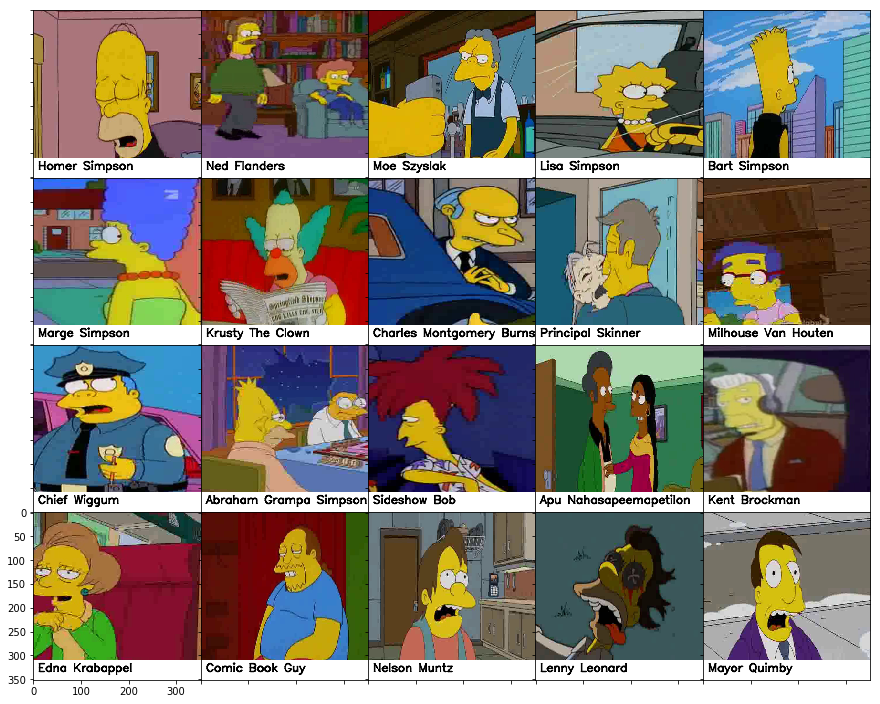

## Загрузка данных

In [1]:
! pip install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.com/d/Ggl9017wNIN0vg) -o simpsons.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/










  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current

                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0

100  529M  100  529M    0     0  9234k      0  0:00:58  0:00:58 --:--:-- 10.1M


In [2]:
! unzip -qq simpsons.zip

In [3]:
import sys
from tqdm import tqdm
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

import albumentations as A

import torchvision
from torchvision import datasets, models, transforms

torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

Зададим преобразования, которые будут совершаться c изображениями перед подачей в нейросеть. Вы можете изменять эти преобразования по своему желанию. 

Обратите внимание, что если вы собираетесь использовать предобученную нейросеть (vgg, resnet, ...), то преобразования должны быть теми же, что использовались при предобучении этой нейросети. Какие преобразования используются для той или иной сети и как использовать их в коде, можно найти в [документации pytorch](https://pytorch.org/vision/stable/models.html).

Если же вы будете обучать свою собственную нейросеть с нуля, вы можете выбирать преобразования по своему усмотрению. 

In [4]:
# общие преобразования для train, val, test
resnet_transforms = transforms.Compose([
    transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
    transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
    transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
])

# # преобразования для конкретной предобученной сети проще получить вот так
# resnet_transforms = models.ResNet18_Weights.IMAGENET1K_V1.transforms()

In [5]:
# дополняем преобразования аугментациями только для трен выборки!
import PIL

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20, interpolation=PIL.Image.BILINEAR),
] + resnet_transforms.transforms)

Создадим датасеты из данных. Обратите внимание, что для тестовых данных вам не известны ответы: внутри папки `./simpsons_data/test` нет подпапок с названиями классов, там всего одна папка со всеми изображениями. Ваша задача — обучить нейросеть, используя тренировочные данные, для которых вам известны ответы, получить с помощью обученной нейросети предсказания для тестовых данных и сдать их в качестве ответа. 

In [6]:
train_val_data = datasets.ImageFolder('./simpsons_data/train', transform=resnet_transforms)
test_data = datasets.ImageFolder('./simpsons_data/test', transform=resnet_transforms)

Разделим тренировочную выборку на две части: тренировочную и валидационную. На тренировочной части, как обычно, будем обучать нейросеть, а на валидационной будем сеть тестировать. 

In [7]:
# в тренировочную выборку отнесем 80% всех картинок
train_size = int(len(train_val_data) * 0.8)
# в валидационную — остальные 20%
val_size = len(train_val_data) - train_size

from copy import copy
train_data, val_data = torch.utils.data.random_split(train_val_data, [train_size, val_size])
train_data.dataset = copy(train_val_data)

In [8]:
# меняем трансформации для трен выборки
train_data.dataset.transform = train_transforms

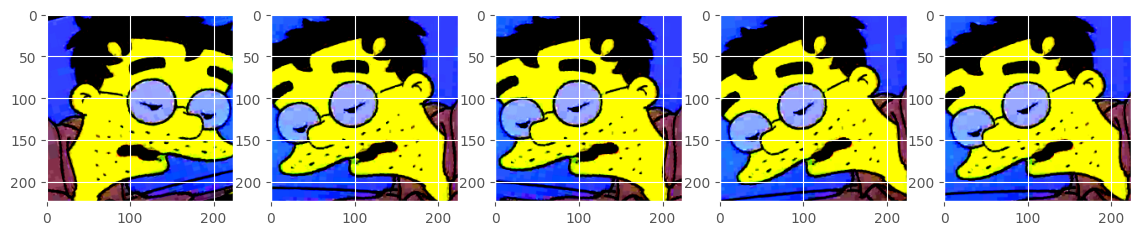

In [9]:
# видно, что при каждом новом вызове ТРЕЙНА с опр вероятностью происходит аугментация
fig, axs = plt.subplots(ncols=5, figsize=(14,7))

for i in range(5):
    axs[i].imshow(train_data[1][0].permute(1,2,0))

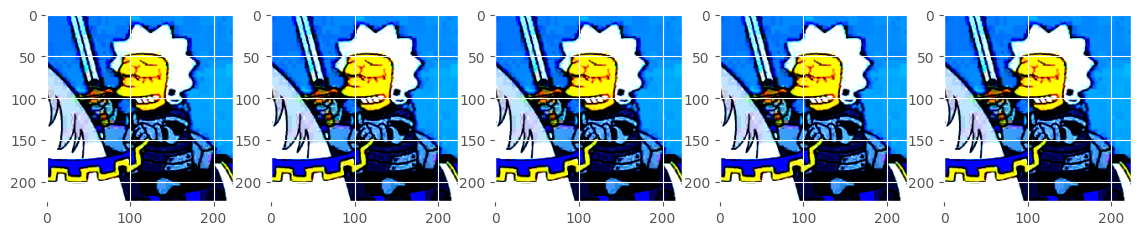

In [10]:
# видно, что при каждом новом вызове ВАЛ-выборки ничего не происходит
fig, axs = plt.subplots(ncols=5, figsize=(14,7))

for i in range(5):
    axs[i].imshow(val_data[1][0].permute(1,2,0))

Создадим три даталоадера для трех частей данных:

In [11]:
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

Получим соответствие номеров классов и их названий:

In [12]:
class_to_idx = train_val_data.class_to_idx
class_to_idx

{'abraham_grampa_simpson': 0,
 'agnes_skinner': 1,
 'apu_nahasapeemapetilon': 2,
 'barney_gumble': 3,
 'bart_simpson': 4,
 'carl_carlson': 5,
 'charles_montgomery_burns': 6,
 'chief_wiggum': 7,
 'cletus_spuckler': 8,
 'comic_book_guy': 9,
 'disco_stu': 10,
 'edna_krabappel': 11,
 'fat_tony': 12,
 'gil': 13,
 'groundskeeper_willie': 14,
 'homer_simpson': 15,
 'kent_brockman': 16,
 'krusty_the_clown': 17,
 'lenny_leonard': 18,
 'lionel_hutz': 19,
 'lisa_simpson': 20,
 'maggie_simpson': 21,
 'marge_simpson': 22,
 'martin_prince': 23,
 'mayor_quimby': 24,
 'milhouse_van_houten': 25,
 'miss_hoover': 26,
 'moe_szyslak': 27,
 'ned_flanders': 28,
 'nelson_muntz': 29,
 'otto_mann': 30,
 'patty_bouvier': 31,
 'principal_skinner': 32,
 'professor_john_frink': 33,
 'rainier_wolfcastle': 34,
 'ralph_wiggum': 35,
 'selma_bouvier': 36,
 'sideshow_bob': 37,
 'sideshow_mel': 38,
 'snake_jailbird': 39,
 'troy_mcclure': 40,
 'waylon_smithers': 41}

И посмотрим на несколько картинок из обучающей выборки, чтобы понимать, с чем мы имеем дело.

In [13]:
for batch in test_loader:
    # батч картинок и батч ответов к картинкам
    images, labels = batch
    break

In [14]:
def show_images(images, labels):
    f, axes= plt.subplots(1, 10, figsize=(30,5))
    
    for i, axis in enumerate(axes):
        # переводим картинку из тензора в numpy
        img = images[i].numpy()
        # переводим картинку в размерность (длина, ширина, цветовые каналы) 
        img = np.transpose(img, (1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(labels[i].numpy())

    plt.show()

Отрисуем картинки. Картинки будут отрисованы уже после преобразований (transforms), поэтому они могут быть не очень естественных цветов, если среди преобразований была нормализация. Не пугайтесь =)

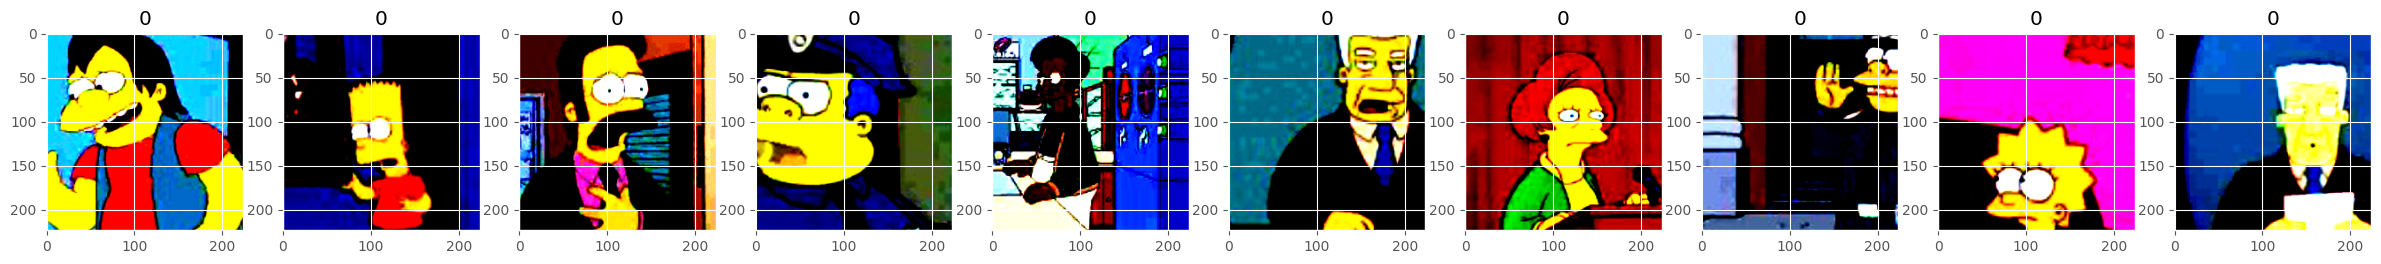

In [15]:
show_images(images, labels)

## Построение и обучение модели

Ваша задача — обучить нейросеть на тренировочных и валидационных данных, и получить предсказания на тестовых данных. Эти предсказания нужно будет отправить в качестве решения на Я.Контест. Ваш итоговый балл будет определяться как значение метрики accuracy, посчитанное между правильными ответами на картинки тестовой выборки, и ответами вашей модели, которые вы отправили в систему.

Для построения и обучения нейросети можно и нужно пользоваться материалами с прошлых семинаров и домашних заданий. 

Идеи, как получить больший скор:
- попробуйте обучить свою нейросеть с нуля, как мы это делали на четвертом занятии и в четвертом домашнем задании. Попробуйте варьировать архитектуру сети и различные гиперпараметры (количество слоев, фильтров в слоях и т.п.), чтобы получить лучший скор на валидации;
- попробуйте взять предобученную нейросеть (resnet-18, к примеру), и дообучить ее на наших данных, как мы это делали на пятом занятии. Обратите внимание на преобразования (transforms): они должны соответствовать той архитектуре, которую вы дообучаете. Попробуйте замораживать разное количество слоев, посмотрите, как это влияет на результат.
- попробуйте применить аугментацию данных для тренировочной выборки. Про аугментацию данных [можно почитать на Хабре](https://habr.com/ru/company/smartengines/blog/264677/). Примеры аугментации в pytorch [можно найти в документации](https://pytorch.org/vision/stable/transforms.html).
Обратите внимание, что аугментация должна применяться только к обучающей (train) выборке. К валидационной и тестовой выборкам она применяться не должна. Поэтому вам нужно будет создать два разных пайплайна transforms: один для тренировочной части, один для валидационной и тестовой частей. 

В процессе обучения сети обращайте внимание на скор на валидации. Значение метрики на валидации — это ориентир, который позволяет понять, как примерно будет вести себя ваша сеть на тестовой выборке. Но обратите внимание, что результат на тестовой и валидационной выборке может отличаться. 

У вас 100 попыток сдачи решения в Я.Контест: это очень много. Но мы просим вас подойти к заданию осознанно. Пожалуйста, не перебирайте ответы бездумно и не посылайте в качестве ответа все подряд. Старайтесь получить хорошую нейросеть перед тем как отправлять ее ответы на Я.Контест.

----------------

Проверяем, доступен ли GPU (если не доступен, включите GPU в настройках ноутбука):

In [16]:
from IPython.display import clear_output

In [17]:
def plot_history(train_history, val_history, title="loss", ylim=None):
    """
    Функция построения графика обучения эпохи.
    - train_history - набор лоссов по всем батчам на всех эпохах
    - val_history - набор средних лоссов по батчам на всех эпохах
    """    
    # подбираем шаг для средних значений val_loss
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.title(title)
    plt.xlabel("train steps")
    plt.grid()
    if ylim:
        plt.ylim(ylim[0],ylim[1])
    
    plt.plot(train_history, label="train", zorder=1)
    plt.scatter(steps, val_history, marker="+", s=180, c="orange", label="val", zorder=2)
    
    plt.legend(loc="best")
    plt.show()

In [18]:
def train_model(model, optimizer, criterion, train_loader, test_loader, n_epochs=5, ylim=None):
    '''
    Функция обучения выбранной модели
    
    Параметры:
        model - модель, унаследованная от torch.nn.Module 
        optimizer - оптимизатор модели
        criterion - функция потерь из torch.nn
        train_loader - тренировочный даталоадер из torch.utils.data.Dataloader 
        test_loader - torch.utils.data.Dataloader with test set
    '''
    
    # логи по всем батчам по всем эпохам
    train_loss_total, val_mean_loss_total = [], []  
    train_acc_total, val_acc_total = [], []
    
    for num_epoch, epoch in enumerate(range(n_epochs)):
        
        # обучение эпохи
        model.train()
        train_loss_epoch, val_loss_epoch = torch.empty(0), torch.empty(0) # лоссы всех батчей по эпохе
        train_loss_epoch, val_loss_epoch = train_loss_epoch.to(device), val_loss_epoch.to(device)
        
        train_corrections_epoch = torch.empty(0) # считаем попадания модели по эпохе (для accuracy)
        train_corrections_epoch = train_corrections_epoch.to(device)
        val_corrections_epoch = torch.empty(0) 
        val_corrections_epoch = val_corrections_epoch.to(device)
        
        with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
            for num_batch, (x_batch, y_batch) in enumerate(train_loader):
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                # шаг оптимизатора по одному батчу
                y_pred = model(x_batch).squeeze(1)
                loss = torch.sqrt(criterion(y_pred, y_batch))
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                # логгируем loss
                train_loss_epoch = torch.cat((train_loss_epoch, loss.unsqueeze(0))) 
                train_loss_total.append(loss.item())                                
                
                # логгируем accuracy
                targets = y_pred.argmax(1)
                train_corrections_epoch = torch.cat((train_corrections_epoch, (y_batch == targets)))
                train_acc_total.append((y_batch == targets).float().mean().item())

                # tqdm вывод
                if num_batch%(len(train_loader)//20)==0:
                    print_loss = train_loss_epoch.mean().item()
                    print_accuracy = train_corrections_epoch.mean().item()
                    pbar.set_description(f"Loss: {round(print_loss,3)} Accuracy: {round(print_accuracy,3)}") 
                pbar.update(1)

        # валидация
        model.eval()
        with tqdm(total=len(test_loader)) as pbar:
            with torch.no_grad():
                for num_batch, (x_batch, y_batch) in enumerate(test_loader):
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                    # находим лосс по батчу
                    y_pred = model(x_batch).squeeze(1)
                    loss = torch.sqrt(criterion(y_pred, y_batch))

                    # логируем loss
                    val_loss_epoch = torch.cat((val_loss_epoch, loss.unsqueeze(0))) # для среднего лосса по эпохе
                    
                    # логгируем accuracy
                    targets = y_pred.argmax(1)
                    val_corrections_epoch = torch.cat((val_corrections_epoch, (y_batch == targets)))
                    
                    # tqdm вывод
                    print_loss = val_loss_epoch.mean().item()
                    print_accuracy = val_corrections_epoch.mean().item()
                    pbar.set_description(f"Loss: {round(print_loss,3)} Accuracy: {round(print_accuracy,3)}") 
                        
                    pbar.update(1)
                    
        val_mean_loss_total.append(val_loss_epoch.mean().item()) # добавляем лосс на текущую эпоху      
        val_acc_total.append(val_corrections_epoch.mean().item())
        
        # визуализация текущего процесса обучения
        clear_output()
        plot_history(train_loss_total, val_mean_loss_total, ylim=ylim, title="loss")
        plot_history(train_acc_total, val_acc_total, ylim=ylim, title="accuracy")
        print(f"{'='*10} Epoch {num_epoch+1} {'='*10}\n")
        print("Train loss:", train_loss_epoch.mean().item())
        print("Val loss:", val_loss_epoch.mean().item())
        print("Train acc:", train_corrections_epoch.mean().item())
        print("Val acc:", val_corrections_epoch.mean().item())

- бейзлайн: резнет18, изменяем голову &rarr; `val_acc = 0.776`
- новый FC слой + дропаут &rarr; `val_acc = 0.707` &rarr; __не берем__
- батч норм + релу + новый FC слой &rarr; `val_acc = 0.79` &rarr; __берем__


## С аугментациями

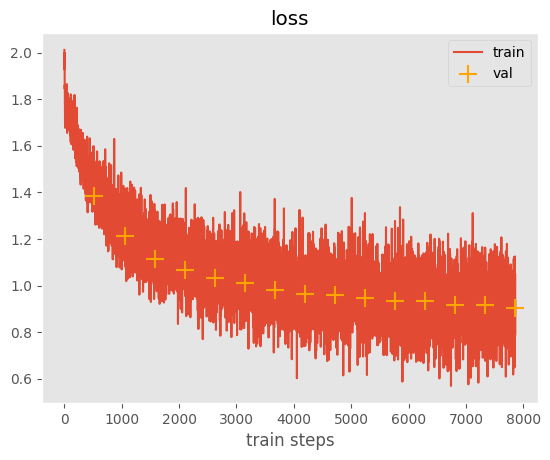

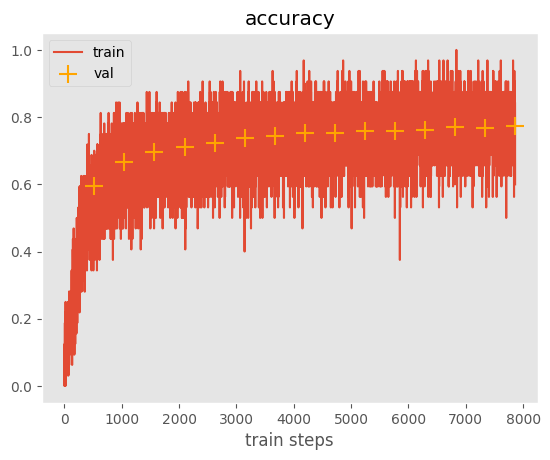

========== Epoch 15 ==========



Train loss: 0.9105140566825867

Val loss: 0.9041796922683716

Train acc: 0.7685417532920837

Val acc: 0.7728683948516846

CPU times: user 59min 9s, sys: 23 s, total: 59min 32s

Wall time: 59min 40s


In [21]:
%%time
from torchvision.models import resnet18

model = resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 42)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

model = model.to(device)
train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    n_epochs=15
)

## Без аугментаций

### Бейзлайн

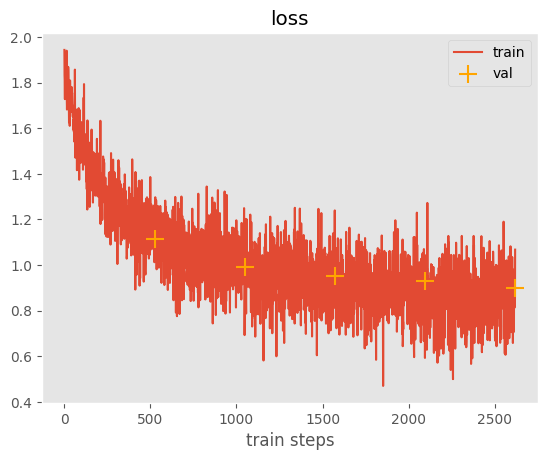

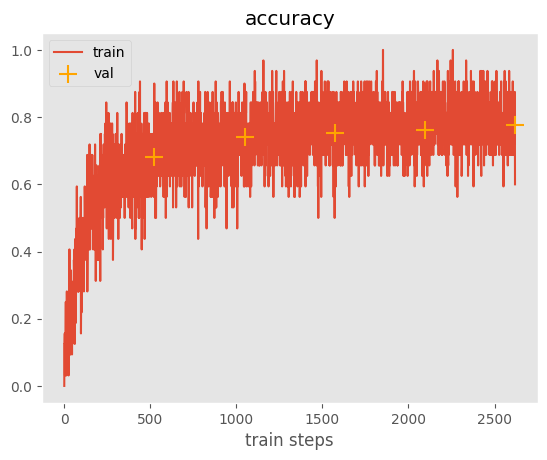

========== Epoch 5 ==========



Train loss: 0.8572506308555603

Val loss: 0.899695873260498

Train acc: 0.7899199724197388

Val acc: 0.7757344245910645

CPU times: user 12min 45s, sys: 7.11 s, total: 12min 52s

Wall time: 12min 59s


In [ ]:
%%time
from torchvision.models import resnet18

model = resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 42)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

model = model.to(device)
train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    n_epochs=5
)

## Батч норм + релу + новый FC слой

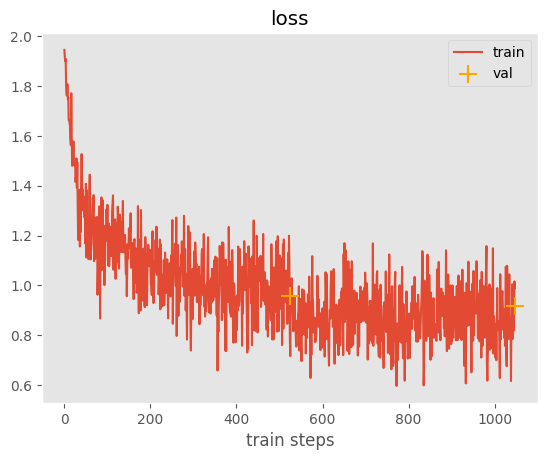

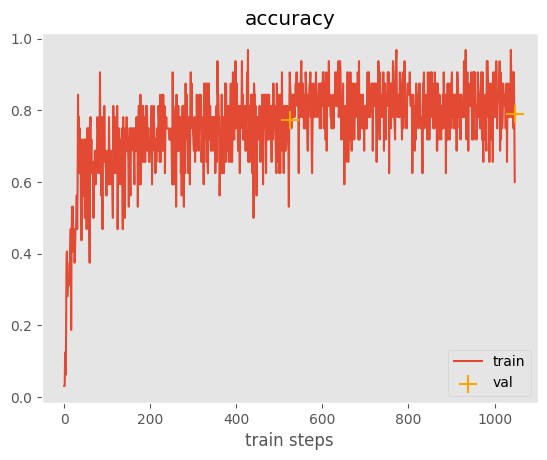

========== Epoch 2 ==========



Train loss: 0.873984158039093

Val loss: 0.9149872064590454

Train acc: 0.8157768845558167

Val acc: 0.7898256778717041

CPU times: user 5min 3s, sys: 2.85 s, total: 5min 6s

Wall time: 5min 7s


In [ ]:
%%time
from torchvision.models import resnet18

model = resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 2000)

optimizer = torch.optim.Adam(model.fc.parameters(), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss()
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

model = torch.nn.Sequential(
    model,
    torch.nn.BatchNorm1d(2000),
    torch.nn.ReLU(),
    torch.nn.Linear(in_features=2000, out_features=42),
)

model = model.to(device)
train_model(
    model=model, 
    optimizer=optimizer,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    n_epochs=2
)

## Получение ответов на тестовую выборку

Функция ниже позволит вам получить ответ вашей модели на тестовую выборку. Файл submission_hw05.npy нужно будет отправить на Я.Контест

In [ ]:
def get_predictions(model, dataloader):
    
    predicted_labels = []
    model.eval()
    predicted_labels = []

    for i, batch in enumerate(dataloader):
        
        # так получаем текущий батч
        X_batch, _ = batch
        
        with torch.no_grad():
            logits = model(X_batch.to(device))
            y_pred = torch.argmax(logits, dim=1)
            predicted_labels.append(y_pred)
    
    predicted_labels = torch.cat(predicted_labels)
    return predicted_labels

# model — переменная, в которой находится ваша модель. 
predicted_labels = get_predictions(model, test_loader)
idx_to_class = {y:x for x, y in class_to_idx.items()}
predicted_labels = [idx_to_class[x] for x in predicted_labels.data.cpu().numpy()]

np.save('submission_hw05.npy', predicted_labels, allow_pickle=True)
print('Ответ сохранен в файл `submission_hw05.npy`')

Ответ сохранен в файл `submission_hw05.npy`
